In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# optimize the types to reduce its size and returns a memory optimized DataFrame.
def memory_reducer(df):
    for col in df.columns:
        # check if is numeric column
        if np.issubdtype(df[col], np.number):

            # check if it can be convert to integer
            if (df[col].dropna() == df[col].dropna().astype(int)).all():
                min = int(df[col].min())
                max = int(df[col].max())

                # Determine and apply the smallest datatype that can fit the range of values
                best_datatype = smallest_datatype(min, max)
                df[col] = df[col].astype(best_datatype)
    
            elif (df[col].dropna() == df[col].dropna().astype(float)).all():
                df[col] = df[col].astype(np.float32)

    return df
# Determine and apply the smallest datatype that can fit the range of values
def smallest_datatype(min, max):
    min_type = np.min_scalar_type(min)
    max_type = np.min_scalar_type(max)

    if min >= 0 or (min < 0 and max < 0):
        datatype = max_type
    elif max_type.itemsize >= min_type.itemsize:
        datatype = np.min_scalar_type(-1*max)

    return datatype

In [3]:
df = pd.read_csv("data/stock_prices.csv", index_col="Date", parse_dates=True, na_values=["?", ""])
df = memory_reducer(df)
print(df.info(), "\n\n")
print(df.index)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3644 entries, 2000-12-12 to 2014-12-30
Columns: 543 entries, A to ZNGA
dtypes: float32(543)
memory usage: 7.6 MB
None 


DatetimeIndex(['2000-12-12', '2000-12-13', '2000-12-14', '2000-12-15',
               '2000-12-18', '2000-12-19', '2000-12-20', '2000-12-21',
               '2000-12-22', '2000-12-26',
               ...
               '2014-12-16', '2014-12-17', '2014-12-18', '2014-12-19',
               '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-26',
               '2014-12-29', '2014-12-30'],
              dtype='datetime64[ns]', name='Date', length=3644, freq=None)


In [4]:
df = df.resample("BME").agg("last")
df = df.stack()
df = df.to_frame(name="Price")
df.index.set_names(["Date", "Ticker"], inplace=True)
df

Price
Date       Ticker            
2000-12-29 A        36.730354
           AA       25.950483
           AAPL      1.006463
           ABC      11.438262
           ABT      38.794544
...                       ...
2014-12-31 YHOO     51.220001
           YUM      73.279999
           ZION     28.670000
           ZMH     114.570000
           ZNGA      2.720000

[85404 rows x 1 columns]

In [5]:
df = df[(df["Price"] >= 0.1) & (df["Price"] <= 10000)].copy()
df["monthly_past_return"] = df.groupby("Ticker")["Price"].pct_change()

#df["monthly_future_return"] = df.groupby("Ticker")["Price"].pct_change(periods=-1)
next_month = df.groupby("Ticker")["Price"].shift(-1)
current_month = df.groupby("Ticker")["Price"].shift(0)
df["monthly_future_return"] = (next_month - current_month) / current_month

df

Price  monthly_past_return  monthly_future_return
Date       Ticker                                                        
2000-12-29 A        36.730354                  NaN              -0.003653
           AA       25.950483                  NaN               0.101194
           AAPL      1.006463                  NaN               0.452957
           ABC      11.438262                  NaN              -0.052871
           ABT      38.794544                  NaN              -0.072050
...                       ...                  ...                    ...
2014-12-31 YHOO     51.220001            -0.010050                    NaN
           YUM      73.279999            -0.051392                    NaN
           ZION     28.670000             0.021739                    NaN
           ZMH     114.570000             0.022272                    NaN
           ZNGA      2.720000             0.046154                    NaN

[83889 rows x 3 columns]

In [6]:
years = df.index.get_level_values("Date").year
excluded_years_mask = (years == 2008) | (years == 2009)

outliers_past = (df["monthly_past_return"] < -0.5) | (df["monthly_past_return"] > 1)
outliers_future = (df["monthly_future_return"] < -0.5) | (df["monthly_future_return"] > 1)

mask_past = outliers_past & ~(excluded_years_mask)
mask_future = outliers_future & ~(excluded_years_mask)

df.loc[mask_past, "monthly_past_return"] = np.nan
df.loc[mask_future, "monthly_future_return"] = np.nan

In [7]:
df["monthly_past_return"] = df.groupby("Ticker")["monthly_past_return"].bfill()
df["monthly_future_return"] = df.groupby("Ticker")["monthly_future_return"].ffill()

print(df.isna().sum())
df = df.dropna()
print(df.isna().sum())

Price                     0
monthly_past_return       8
monthly_future_return    10
dtype: int64
Price                    0
monthly_past_return      0
monthly_future_return    0
dtype: int64


In [8]:
df1 = pd.read_csv("data/sp500.csv", index_col="Date", parse_dates=True, na_values=["?", ""])
df1 = memory_reducer(df1)
print(df1.info(), "\n\n")
print(df1.index)
df1

df1 = df1.resample("BME").agg("last")
df1["monthly returns"] = df1["Adjusted Close"].pct_change()
df1

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3770 entries, 2014-12-26 to 2000-01-03
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            3770 non-null   float32
 1   High            3770 non-null   float32
 2   Low             3770 non-null   float32
 3   Close           3770 non-null   float32
 4   Volume          3770 non-null   uint64 
 5   Adjusted Close  3770 non-null   float32
dtypes: float32(5), uint64(1)
memory usage: 132.5 KB
None 


DatetimeIndex(['2014-12-26', '2014-12-24', '2014-12-23', '2014-12-22',
               '2014-12-19', '2014-12-18', '2014-12-17', '2014-12-16',
               '2014-12-15', '2014-12-12',
               ...
               '2000-01-14', '2000-01-13', '2000-01-12', '2000-01-11',
               '2000-01-10', '2000-01-07', '2000-01-06', '2000-01-05',
               '2000-01-04', '2000-01-03'],
              dtype='datetime64[ns]', name='Date', length=3770, f

,Open,High,Low,Close,Volume,Adjusted Close,monthly returns
Date,,,,,,,
2000-01-31,1360.160034,1394.479980,1350.140015,1394.459961,993800000,1394.459961,NaN
2000-02-29,1348.050049,1369.630005,1348.050049,1366.420044,1204300000,1366.420044,-0.020108
2000-03-31,1487.920044,1519.810059,1484.380005,1498.579956,1227400000,1498.579956,0.096720
2000-04-28,1464.920044,1473.619995,1448.150024,1452.430054,984600000,1452.430054,-0.030796
2000-05-31,1422.439941,1434.489990,1415.500000,1420.599976,960500000,1420.599976,-0.021915
...,...,...,...,...,...,...,...
2014-08-29,1998.449951,2003.380005,1994.650024,2003.369995,2259130000,2003.369995,0.037655
2014-09-30,1978.209961,1985.170044,1968.959961,1972.290039,3951100000,1972.290039,-0.015514
2014-10-31,2001.199951,2018.189941,2001.199951,2018.050049,4292290000,2018.050049,0.023201


In [9]:

df = df.reset_index()

df["average_return_1y"] = (
    df.groupby("Ticker")["monthly_past_return"]
    .rolling(12).mean()
    .reset_index(level=0, drop=True)
)

df.set_index(["Date", "Ticker"], inplace=True)
df

Price  monthly_past_return  monthly_future_return  \
Date       Ticker                                                           
2000-12-29 A        36.730354            -0.003653              -0.003653   
           AA       25.950483             0.101194               0.101194   
           AAPL      1.006463             0.452957               0.452957   
           ABC      11.438262            -0.052871              -0.052871   
           ABT      38.794544            -0.072050              -0.072050   
...                       ...                  ...                    ...   
2014-12-31 YHOO     51.220001            -0.010050              -0.010050   
           YUM      73.279999            -0.051392              -0.051392   
           ZION     28.670000             0.021739               0.021739   
           ZMH     114.570000             0.022272               0.022272   
           ZNGA      2.720000             0.046154               0.046154   

                   average_return_1y  
Date       Ticker                     
2000-12-29 A                     NaN  
           AA                    NaN  
           AAPL                  NaN  
           ABC                   NaN  
           ABT                   NaN  
...                              ...  
2014-12-31 YHOO             0.022356  
           YUM              0.001508  
           ZION            -0.002527  
           ZMH              0.018724  
           ZNGA            -0.022851  

[83878 rows x 4 columns]

In [10]:
df = df.sort_values(by=["Date", "average_return_1y"], ascending=[True, False])
df

df["signal"] = False
top20_indices = df.groupby("Date").head(20).index
df.loc[top20_indices, "signal"] = True
df

Price  monthly_past_return  monthly_future_return  \
Date       Ticker                                                           
2000-12-29 A        36.730354            -0.003653              -0.003653   
           AA       25.950483             0.101194               0.101194   
           AAPL      1.006463             0.452957               0.452957   
           ABC      11.438262            -0.052871              -0.052871   
           ABT      38.794544            -0.072050              -0.072050   
...                       ...                  ...                    ...   
2014-12-31 SD        1.900000            -0.323843              -0.323843   
           ARO       2.370000            -0.318966              -0.318966   
           CLF       6.900000            -0.243421              -0.243421   
           MCP       0.861500            -0.129798              -0.129798   
           GOOG    530.419983            -0.021058              -0.021058   

                   average_return_1y  signal  
Date       Ticker                             
2000-12-29 A                     NaN    True  
           AA                    NaN    True  
           AAPL                  NaN    True  
           ABC                   NaN    True  
           ABT                   NaN    True  
...                              ...     ...  
2014-12-31 SD              -0.082279   False  
           ARO             -0.089951   False  
           CLF             -0.092395   False  
           MCP             -0.129730   False  
           GOOG                  NaN   False  

[83878 rows x 5 columns]

In [11]:
df["Pnl"] = df["signal"] * df["monthly_future_return"]
strategy_return_prices = df["Pnl"].sum() / df["signal"].sum()
strategy_return_prices

df

Price  monthly_past_return  monthly_future_return  \
Date       Ticker                                                           
2000-12-29 A        36.730354            -0.003653              -0.003653   
           AA       25.950483             0.101194               0.101194   
           AAPL      1.006463             0.452957               0.452957   
           ABC      11.438262            -0.052871              -0.052871   
           ABT      38.794544            -0.072050              -0.072050   
...                       ...                  ...                    ...   
2014-12-31 SD        1.900000            -0.323843              -0.323843   
           ARO       2.370000            -0.318966              -0.318966   
           CLF       6.900000            -0.243421              -0.243421   
           MCP       0.861500            -0.129798              -0.129798   
           GOOG    530.419983            -0.021058              -0.021058   

                   average_return_1y  signal       Pnl  
Date       Ticker                                       
2000-12-29 A                     NaN    True -0.003653  
           AA                    NaN    True  0.101194  
           AAPL                  NaN    True  0.452957  
           ABC                   NaN    True -0.052871  
           ABT                   NaN    True -0.072050  
...                              ...     ...       ...  
2014-12-31 SD              -0.082279   False -0.000000  
           ARO             -0.089951   False -0.000000  
           CLF             -0.092395   False -0.000000  
           MCP             -0.129730   False -0.000000  
           GOOG                  NaN   False -0.000000  

[83878 rows x 6 columns]

In [12]:
signal_serie = pd.Series(index=df1.index, data=20)
df1["Pnl"] = signal_serie * df1["monthly returns"]
strategy_return_sp500 = df1["Pnl"].sum() / signal_serie.sum()
strategy_return_sp500

np.float64(0.003219234612252977)

In [123]:

reset_ind_df = df.reset_index()
reset_ind_df = reset_ind_df.groupby("Date").agg("sum")
reset_ind_df


,Ticker,Price,monthly_past_return,monthly_future_return,average_return_1y,signal,Pnl
Date,,,,,,,
2000-12-29,AAAAAPLABCABTACEACIACTADBEADIADMADPADSKAEEAEOA...,12236.925781,19.465395,19.465395,0.000000,20,0.435323
2001-01-31,AAAAAPLABCABTACEACIACTADBEADIADMADPADSKAEEAEOA...,12607.381836,19.435514,-8.844834,0.000000,20,-0.282833
2001-02-28,AAAAAPLABCABTACEACIACTADBEADIADMADPADSKAEEAEOA...,11499.569336,-12.319375,-18.832205,0.000000,20,-0.591780
2001-03-30,AAAAAPLABCABTACEACIACTADBEADIADMADPADSKAEEAEOA...,10639.166016,-19.290215,40.881828,0.000000,20,1.534526
2001-04-30,AAAAAPLABCABTACEACIACTADBEADIADMADPADSKAEEAEOA...,11568.733398,40.423820,15.623683,0.000000,20,0.061550
...,...,...,...,...,...,...,...
2014-08-29,LUVMUXAADALFSLRBKSECYTNFXUAAGNEXPEFBHARNBRTSLA...,38452.292969,20.952747,-16.390936,9.740847,20,-0.881573
2014-09-30,LUVXAGNAAMUGMCRMNSTECYTBKSUAFSLREXPEGILDHPQSND...,37527.269531,-16.392189,14.412156,6.537884,20,0.422014
2014-10-31,GMCRECYTAGNLUVMUMNSTEWBKSAATSLAXMARUAFLWMBEASI...,38587.703125,14.790304,11.516759,6.167332,20,0.777133


Date        Ticker
2000-12-29  A         -0.003653
            AA         0.097541
            AAPL       0.550498
            ABC        0.497627
            ABT        0.425577
                        ...    
2014-12-31  SD        69.794685
            ARO       69.794685
            CLF       69.794685
            MCP       69.794685
            GOOG      69.794685
Name: Pnl, Length: 83878, dtype: float32

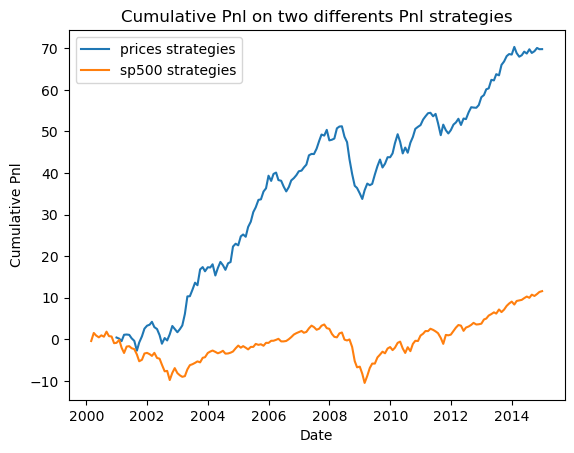

In [124]:
plt.plot(reset_ind_df.index, reset_ind_df["Pnl"].cumsum(), label="prices strategies")
plt.plot(df1.index, df1["Pnl"].cumsum(), label="sp500 strategies")

plt.title("Cumulative Pnl on two differents Pnl strategies")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cumulative Pnl")

df["Pnl"].cumsum()



In [125]:
for name in dir():
    if not name.startswith('_'):
        del globals()[name]
